In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from pytorch_lightning import Trainer, seed_everything

from torch.utils.data import DataLoader

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger
from anomalib.data.inference import InferenceDataset
from anomalib.post_processing.post_process import compute_mask

import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.segmentation import find_boundaries
from skimage.morphology import dilation



In [6]:
config_path = 'patchcore_config.yaml'

In [4]:
config = get_configurable_parameters(model_name='patchcore', config_path=config_path)
if config.project.seed:
    seed_everything(config.project.seed)

datamodule = get_datamodule(config)
model = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks = get_callbacks(config)

Transform configs has not been provided. Images will be normalized using ImageNet statistics.
Transform configs has not been provided. Images will be normalized using ImageNet statistics.
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/utils/callbacks/__init__.py:143: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")


In [5]:
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/data/folder.py:216: UserWarning: Segmentation task is requested, but mask directory is not provided. Classification is to be chosen if mask directory is not provided.
  warnings.warn(
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/data/folder.py:216: UserWarning: Segmentation task is requested, 

Epoch 0:  17%|█▋        | 1/6 [00:17<01:28, 17.74s/it, loss=nan]

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:137: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Epoch 0:  83%|████████▎ | 5/6 [00:56<00:11, 11.25s/it, loss=nan]

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/models/patchcore/torch_model.py:182: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = (1 - F.softmax(distances.squeeze()))[..., 0]


Epoch 0: 100%|██████████| 6/6 [32:06<00:00, 321.11s/it, loss=nan, image_F1Score=0.000, image_AUROC=0.000]

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 0: 100%|██████████| 6/6 [32:07<00:00, 321.22s/it, loss=nan, image_F1Score=0.000, image_AUROC=0.000]


In [7]:
config = get_configurable_parameters(config_path=config_path)
config.trainer.resume_from_checkpoint = str('results/patchcore/idrid/weights/model.ckpt')
config.visualization.show_images = False
#config.visualization.mode = args.visualization_mode
config.visualization.save_images = False
config.visualization.image_save_path = '../results'

model = get_model(config)
callbacks = get_callbacks(config)

trainer = Trainer(callbacks=callbacks, **config.trainer)

transform_config = config.dataset.transform_config.val if "transform_config" in config.dataset.keys() else None
dataset = InferenceDataset(
    '../data/abnormal_test_img/IDRiD_001.jpg', image_size=tuple(config.dataset.image_size), transform_config=transform_config
)

dataloader = DataLoader(dataset)
results = trainer.predict(model=model, dataloaders=[dataloader])


/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/utils/callbacks/__init__.py:143: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:51: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/toon/anomalib-demo/.venv/lib/python3.8/site-packages/anomalib/models/patchcore/torch_model.py:182: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = (1 - F.softmax(distances.squeeze()))[..., 0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


In [11]:
results

[{'image': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            ...,
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
  
           [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            ...,
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
  
           [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.804

In [16]:
def add_boundary(image, anomaly_map, threshold=0.5, thickness=20, color=(255, 0, 0)):
     marked = np.copy(image)
     anomaly_mask = compute_mask(anomaly_map, threshold)
     boundaries = find_boundaries(anomaly_mask)
     outlines = dilation(boundaries, np.ones((thickness, thickness)))
     image[outlines] = color
     return image

img = cv2.imread('../data/abnormal_test_img/IDRiD_001.jpg')[:,:,::-1]
anomaly_map = np.squeeze(results[0]['anomaly_maps'].numpy())
anomaly_map_original_size = cv2.resize(anomaly_map, (img.shape[1], img.shape[0]))
segmentation_boundary = add_boundary(img, anomaly_map_original_size, threshold=0.3)

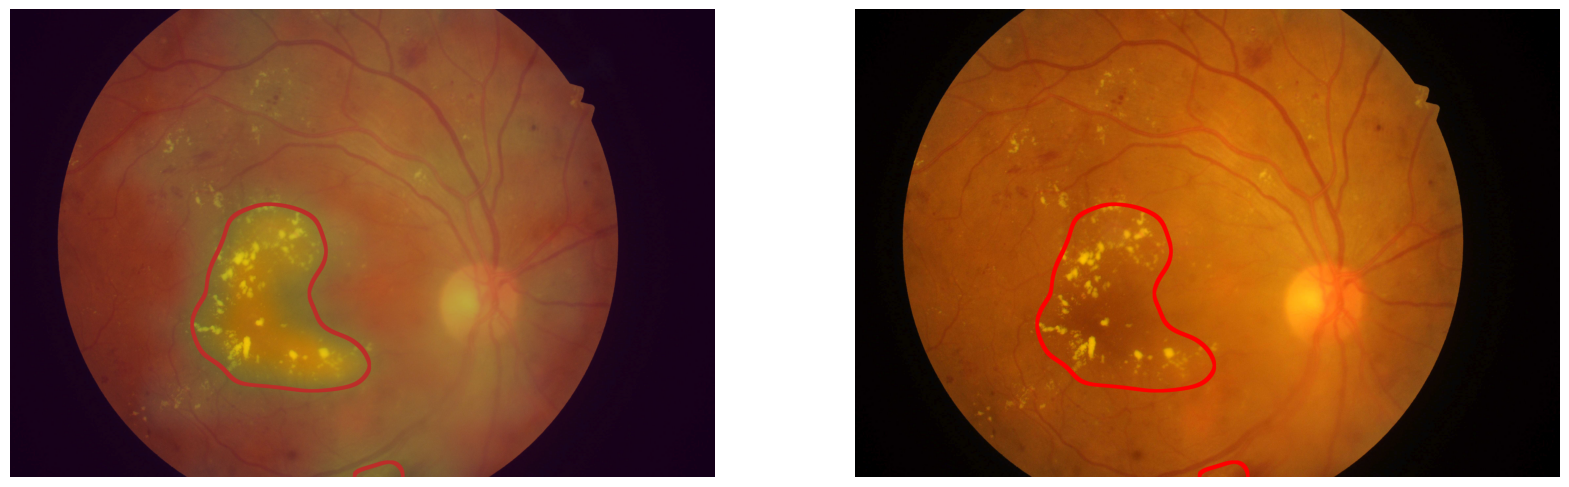

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.imshow(anomaly_map_original_size, alpha=0.3)
plt.subplot(1,2,2)
plt.imshow(segmentation_boundary)
plt.axis('off')
plt.show()